In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/lib/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches


import itertools
import torch
import torchvision
import torchvision.transforms as transform

import datasets.dataset as dataset
import models.own_blocks as models
import torch
import cv2

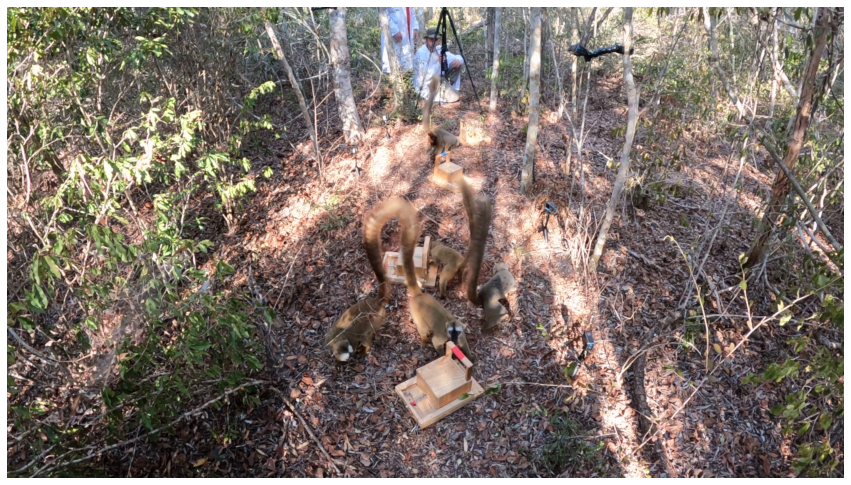

In [2]:
# Load the video
video_path = '../../sfb1528s3/B06/2022Sept/Experiments_sync2/alpha/a_e_1_220918_c6.mp4'
cap = cv2.VideoCapture(video_path)

# Set the frame position
frame_position = 3000 #14000
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_position)

# Read the frame
ret, frame = cap.read()

if ret:
    # Convert BGR to RGB for displaying with matplotlib
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Display the frame using matplotlib
    plt.figure(figsize=(15, 15))  # Set the figure size
    plt.imshow(frame_rgb)
    plt.axis('off')  # Turn off axis
    plt.show()
else:
    print("Failed to read the frame.")

# Release the video capture
cap.release()


In [3]:
# Define the file path
file_path = "../../sfb1528s3/B06/2022Sept/Experiments_sync2/alpha/a_e_1_220918_c6.txt"
#'../../sfb1528s3/B06/2023april-july/NewBoxesClosed/Converted/Alpha/A_e1_c6.txt'
#

# Read the file with pandas
df = pd.read_csv(file_path, header=None)

# Set header to ['frame', 'id', 'x', 'y', 'w', 'h', 'class']
df.columns = ['frame', 'id', 'x', 'y', 'w', 'h', 'conf', 'class']

# Convert all columns to numeric
df = df.apply(pd.to_numeric, errors='coerce')

df_filtered = df[(df['frame'] == frame_position) & (df['class'] == 0)]



In [4]:
df_filtered

,frame,id,x,y,w,h,conf,class
7122,3000,12,718.649876,658.374580,164.638302,168.709938,0.973369,0
7123,3000,10,960.944732,537.830099,89.458936,131.565951,0.874387,0
7124,3000,19,915.747534,654.286202,153.553266,172.240874,0.960280,0
7125,3000,18,967.421824,275.210284,74.791439,71.796854,0.764143,0
7126,3000,20,1033.910274,589.218479,173.278443,159.821871,0.972245,0


In [5]:
import itertools
import torch
import torchvision


# Extract the coordinates of subj and obj from filtered_df
subj_coords = df_filtered[['x', 'y', 'w', 'h']].values
obj_coords = df_filtered[['x', 'y', 'w', 'h']].values

# Generate all combinations of subj and obj
combinations = list(itertools.product(subj_coords, obj_coords))

# Remove combinations where subj == obj
combinations = [c for c in combinations if not np.array_equal(c[0], c[1])]

# Print the combinations
import torchvision.transforms as transforms

# Define a transform to resize the images to 224x224
resize_transform = transforms.Resize((224, 224))

# Define a list to store the cropped and resized images
cropped_resized_images = []

# Iterate over each combination
for subj, obj in combinations:
    # Extract the coordinates of subj and obj
    subj_x, subj_y, subj_w, subj_h = map(int, subj)
    obj_x, obj_y, obj_w, obj_h = map(int, obj)
    
    # Calculate the coordinates of the union
    union_x = min(subj_x, obj_x)
    union_y = min(subj_y, obj_y)
    union_w = max(subj_x + subj_w, obj_x + obj_w) - union_x
    union_h = max(subj_y + subj_h, obj_y + obj_h) - union_y
    
    # Crop the subj, obj, and union from the frame
    subj_crop = frame[subj_y:subj_y+subj_h, subj_x:subj_x+subj_w]
    obj_crop = frame[obj_y:obj_y+obj_h, obj_x:obj_x+obj_w]
    union_crop = frame[union_y:union_y+union_h, union_x:union_x+union_w]
    
    # Resize the cropped images to 224x224
    subj_resized = cv2.resize(subj_crop, (224, 224))
    obj_resized = cv2.resize(obj_crop, (224, 224))
    union_resized = cv2.resize(union_crop, (224, 224))
    
    # Convert the resized images to tensors
    transform = transforms.ToTensor()
    subj_tensor = transform(subj_resized)
    obj_tensor = transform(obj_resized)
    union_tensor = transform(union_resized)
    
    # Store the cropped and resized images
    cropped_resized_images.append((subj_tensor, obj_tensor, union_tensor))

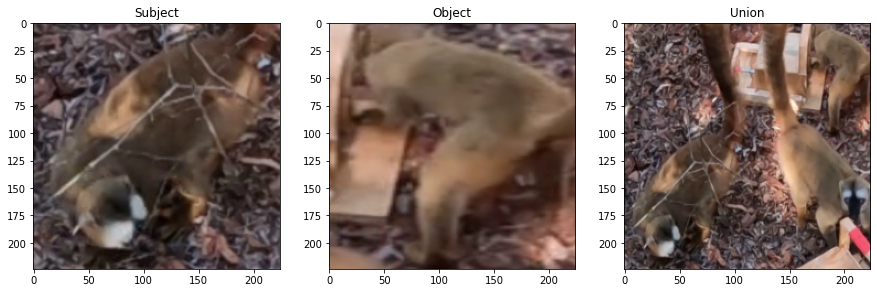

In [6]:
import matplotlib.pyplot as plt

# Display the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

subj_tensor, obj_tensor, union_tensor = cropped_resized_images[0]

# Convert the tensors to numpy arrays
subj_np = subj_tensor.numpy()
obj_np = obj_tensor.numpy()
union_np = union_tensor.numpy()

# Display the images
axes[0].imshow(subj_np.transpose(1, 2, 0)[..., ::-1])
axes[1].imshow(obj_np.transpose(1, 2, 0)[..., ::-1])
axes[2].imshow(union_np.transpose(1, 2, 0)[..., ::-1])
axes[0].set_title('Subject')
axes[1].set_title('Object')
axes[2].set_title('Union')

plt.show()

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the saved model
loaded_model = models.InteractionDetection()
loaded_model.load_state_dict(torch.load("../exp/interactions/padded_boxes/model_epoch_3.pth"))
loaded_model.to(device)

loaded_model.eval()

predictions = []


for i, (subj, obj, union) in enumerate(cropped_resized_images):

    subj = subj.unsqueeze(0).to(device)
    obj = obj.unsqueeze(0).to(device)
    union = union.unsqueeze(0).to(device)

    # Multiply the values with 255.0
    subj *= 255.0
    obj *= 255.0
    union *= 255.0

    with torch.no_grad():
        # Apply the loaded model to the data
        outputs = loaded_model(subj=subj, obj=obj, union=union)
        print(outputs)
        _, predicted_labels = torch.max(outputs, 1)
        predictions.append(predicted_labels.item())

        # Print the predicted label
        print(f"Interaction {i+1}: {predicted_labels.item()}")

        # # Display the images with predicted_labels==1
        # fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # subj_np = subj.squeeze().cpu().numpy().transpose(1, 2, 0)[..., ::-1] / 255
        # obj_np = obj.squeeze().cpu().numpy().transpose(1, 2, 0)[..., ::-1] / 255
        # union_np = union.squeeze().cpu().numpy().transpose(1, 2, 0)[..., ::-1] / 255

        # axes[0].imshow(subj_np)
        # axes[1].imshow(obj_np)
        # axes[2].imshow(union_np)

        # axes[0].set_title('Subject')
        # axes[1].set_title('Object')
        # axes[2].set_title('Union')

        # plt.show()


tensor([[ 2.5221, -2.5491]], device='cuda:0')
Interaction 1: 0
tensor([[ 1.1057, -1.0663]], device='cuda:0')
Interaction 2: 0
tensor([[ 0.9870, -0.9670]], device='cuda:0')
Interaction 3: 0
tensor([[ 0.5329, -0.4787]], device='cuda:0')
Interaction 4: 0
tensor([[ 0.3664, -0.3345]], device='cuda:0')
Interaction 5: 0
tensor([[ 0.9856, -0.9822]], device='cuda:0')
Interaction 6: 0
tensor([[0.0271, 0.0795]], device='cuda:0')
Interaction 7: 1
tensor([[-0.3544,  0.4859]], device='cuda:0')
Interaction 8: 1
tensor([[ 0.1899, -0.1041]], device='cuda:0')
Interaction 9: 0
tensor([[ 2.3087, -2.3226]], device='cuda:0')
Interaction 10: 0
tensor([[ 0.1806, -0.0550]], device='cuda:0')
Interaction 11: 0
tensor([[-0.2534,  0.4153]], device='cuda:0')
Interaction 12: 1
tensor([[ 1.0207, -1.0101]], device='cuda:0')
Interaction 13: 0
tensor([[ 2.3159, -2.3157]], device='cuda:0')
Interaction 14: 0
tensor([[ 1.1441, -1.1014]], device='cuda:0')
Interaction 15: 0
tensor([[ 0.6366, -0.5699]], device='cuda:0')
Inter

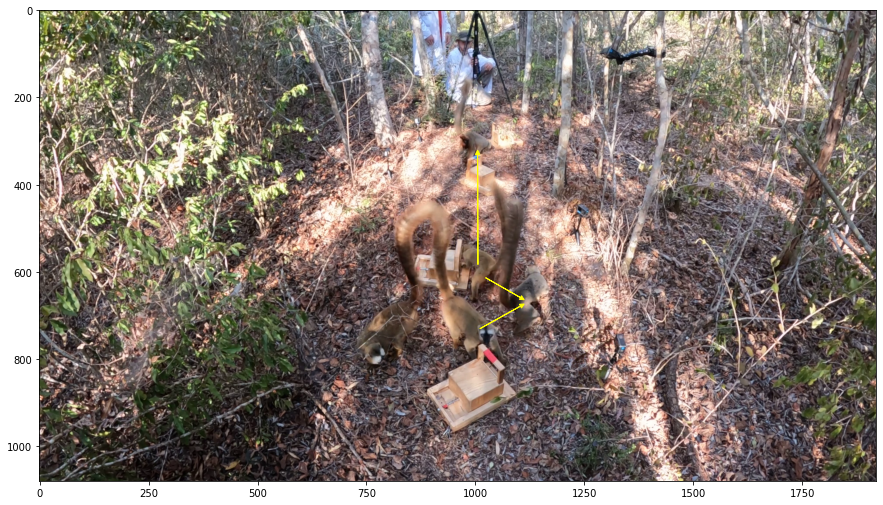

In [9]:


# Display the image with arrows
plt.figure(figsize=(15, 12))  # Set the figure size
plt.imshow(frame_rgb)


offset_distance = 20

for i, (subj, obj) in enumerate(combinations):
    # Check if the predicted label is 1
    if predictions[i] == 1:
        # Calculate the midpoint of subj and obj coordinates
        subj_midpoint_x = subj[0] + subj[2] / 2
        subj_midpoint_y = subj[1] + subj[3] / 2
        obj_midpoint_x = obj[0] + obj[2] / 2
        obj_midpoint_y = obj[1] + obj[3] / 2

        # Vector from subj midpoint to obj midpoint
        dx = obj_midpoint_x - subj_midpoint_x
        dy = obj_midpoint_y - subj_midpoint_y

        # Calculate the length of the vector
        vector_length = np.sqrt(dx**2 + dy**2)

        # Normalize the vector to get the unit vector
        unit_dx = dx / vector_length
        unit_dy = dy / vector_length

        # Adjust the starting and ending points by the offset distance
        # Arrow starts a little away from the subj midpoint
        arrow_start_x = subj_midpoint_x + unit_dx * offset_distance
        arrow_start_y = subj_midpoint_y + unit_dy * offset_distance

        # Arrow ends a little away from the obj midpoint
        arrow_end_x = obj_midpoint_x - unit_dx * offset_distance
        arrow_end_y = obj_midpoint_y - unit_dy * offset_distance

        # Draw an arrow from subj midpoint to obj midpoint with ends
        arrow = patches.FancyArrow(arrow_start_x, arrow_start_y, arrow_end_x - arrow_start_x, arrow_end_y - arrow_start_y, color='yellow', head_width=10, head_length=10)
        plt.gca().add_patch(arrow)

plt.show()


### Process a complete video

In [16]:
# Load the video
video_path = '../../sfb1528s3/B06/2022Sept/Experiments_sync2/alpha/a_e_1_220918_c6.mp4'
cap = cv2.VideoCapture(video_path)

# Read the annotations
file_path = "../../sfb1528s3/B06/2022Sept/Experiments_sync2/alpha/a_e_1_220918_c6.txt"
#'../../sfb1528s3/B06/2023april-july/NewBoxesClosed/Converted/Alpha/A_e1_c6.txt'

df = pd.read_csv(file_path, header=None)
df.columns = ['frame', 'id', 'x', 'y', 'w', 'h', 'conf', 'class']
df = df.apply(pd.to_numeric, errors='coerce')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the saved model
loaded_model = models.InteractionDetection()
loaded_model.load_state_dict(torch.load("../exp/interactions/first_try/model_epoch_4_first.pth"))
loaded_model.to(device)
loaded_model.eval()

# Define a transform to resize the images to 224x224
resize_transform = transforms.Resize((224, 224))



# Set the frame position
frame_position = 3010 #14000

for frame_position in range(2000, 3000):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_position)

    # Read the frame
    _, frame = cap.read()
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    df_filtered = df[(df['frame'] == frame_position) & (df['class'] == 0)]

    


    # Extract the coordinates of subj and obj from filtered_df
    subj_coords = df_filtered[['x', 'y', 'w', 'h']].values
    obj_coords = df_filtered[['x', 'y', 'w', 'h']].values

    # Generate all combinations of subj and obj
    combinations = list(itertools.product(subj_coords, obj_coords))

    # Remove combinations where subj == obj
    combinations = [c for c in combinations if not np.array_equal(c[0], c[1])]


    # Define a list to store the cropped and resized images
    cropped_resized_images = []

    # Iterate over each combination
    for subj, obj in combinations:
        # Extract the coordinates of subj and obj
        subj_x, subj_y, subj_w, subj_h = map(int, subj)
        obj_x, obj_y, obj_w, obj_h = map(int, obj)
        
        # Calculate the coordinates of the union
        union_x = min(subj_x, obj_x)
        union_y = min(subj_y, obj_y)
        union_w = max(subj_x + subj_w, obj_x + obj_w) - union_x
        union_h = max(subj_y + subj_h, obj_y + obj_h) - union_y
        
        # Crop the subj, obj, and union from the frame
        subj_crop = frame[subj_y:subj_y+subj_h, subj_x:subj_x+subj_w]
        obj_crop = frame[obj_y:obj_y+obj_h, obj_x:obj_x+obj_w]
        union_crop = frame[union_y:union_y+union_h, union_x:union_x+union_w]
        
        # Resize the cropped images to 224x224
        subj_resized = cv2.resize(subj_crop, (224, 224))
        obj_resized = cv2.resize(obj_crop, (224, 224))
        union_resized = cv2.resize(union_crop, (224, 224))
        
        # Convert the resized images to tensors
        transform = transforms.ToTensor()
        subj_tensor = transform(subj_resized)
        obj_tensor = transform(obj_resized)
        union_tensor = transform(union_resized)
        
        # Store the cropped and resized images
        cropped_resized_images.append((subj_tensor, obj_tensor, union_tensor))


    predictions = []

    for i, (subj, obj, union) in enumerate(cropped_resized_images):

        subj = subj.unsqueeze(0).to(device)
        obj = obj.unsqueeze(0).to(device)
        union = union.unsqueeze(0).to(device)

        subj *= 255.0
        obj *= 255.0
        union *= 255.0

        with torch.no_grad():
            # Apply the loaded model to the data
            outputs = loaded_model(subj=subj, obj=obj, union=union)
            _, predicted_labels = torch.max(outputs, 1)
            predictions.append(predicted_labels.item())

            #print(f"Interaction {i+1}: {predicted_labels.item()}")

    # Display the image with arrows
    plt.figure(figsize=(15, 12))  # Set the figure size
    plt.imshow(frame_rgb)

    offset_distance = 20

    for j, (subj, obj) in enumerate(combinations):
        # Check if the predicted label is 1 - then draw error
        if predictions[j] == 1:
            # Calculate the midpoint of subj and obj coordinates
            subj_midpoint_x = subj[0] + subj[2] / 2
            subj_midpoint_y = subj[1] + subj[3] / 2
            obj_midpoint_x = obj[0] + obj[2] / 2
            obj_midpoint_y = obj[1] + obj[3] / 2

            # Vector from subj midpoint to obj midpoint
            dx = obj_midpoint_x - subj_midpoint_x
            dy = obj_midpoint_y - subj_midpoint_y
            vector_length = np.sqrt(dx**2 + dy**2)

            # Normalize the vector to get the unit vector
            unit_dx = dx / vector_length
            unit_dy = dy / vector_length

            # Adjust the starting and ending points by the offset distance
            # Arrow starts a little away from the subj midpoint
            arrow_start_x = subj_midpoint_x + unit_dx * offset_distance
            arrow_start_y = subj_midpoint_y + unit_dy * offset_distance
            arrow_end_x = obj_midpoint_x - unit_dx * offset_distance
            arrow_end_y = obj_midpoint_y - unit_dy * offset_distance

            # Draw an arrow from subj midpoint to obj midpoint with ends
            arrow = patches.FancyArrow(arrow_start_x, arrow_start_y, arrow_end_x - arrow_start_x, arrow_end_y - arrow_start_y, color='yellow', head_width=10, head_length=10)
            plt.gca().add_patch(arrow)

    # Save the figure to a folder
    plt.savefig(f'../videos/interactions/a_e_1_220918_c6/predictions/frame_{frame_position}.png')
    plt.close()
# Release the video capture
cap.release()

